In [1]:
# import
from matplotlib import pyplot as plt
from nptdms import TdmsFile # https://nptdms.readthedocs.io/en/stable/
import numpy as np
from scipy import signal as sig
import control
%matplotlib widget

In [9]:
# read in tdms file
file = TdmsFile.read("tdms/mike6_PB_5.tdms")

In [10]:
p_set = file["Position_Bandwidth"]["Position Setpoint [deg]"][:]
p_meas = file["Position_Bandwidth"]["Position [deg]"][:]
time = file["Position_Bandwidth"]["Time (s) "][:]
time = time-time[0]
freq = max(file["Position_Bandwidth"]["Frequency [Hz]"][:])

In [11]:
# delete data for which the setpoint is zero
p_meas = p_meas[np.nonzero(p_set)]
time = time[np.nonzero(p_set)]
p_set = p_set[np.nonzero(p_set)]

In [12]:
# filtering mith a low pass butterworth filter
fs = 1/np.mean(np.diff(time))

if freq >= 1:
    fc = 60
else:
    fc = 10

b,a = sig.butter(1,fc/(fs/2),'low')
p_meas = sig.filtfilt(b,a,p_meas)

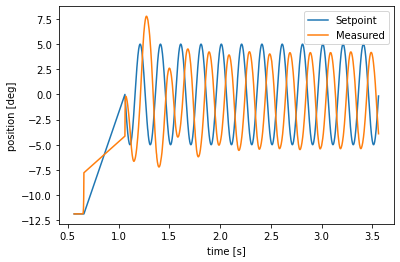

In [13]:
# plotting, here you can compare the peak measurements to the real signal (can help for debugging)
plt.clf()
plt.plot(time, p_set, label='Setpoint')
plt.plot(time, p_meas, label='Measured')
plt.legend(loc='upper right')
plt.xlabel("time [s]")
plt.ylabel("position [deg]")
plt.show()

In [7]:
# processing
distance = (1/(3*freq))/0.001 # minimal x-distance in measurements between two conscuitve peaks
m_loc_max, m_peaks_max = sig.find_peaks(p_meas, distance = distance)
s_loc_max, s_peaks_max = sig.find_peaks(p_set, height=4) # peak must be at a minimum height of 4
m_loc_min, m_peaks_min = sig.find_peaks(-p_meas, distance = distance)
s_loc_min, s_peaks_min = sig.find_peaks(-p_set, height=4)

m_peaks_max = p_meas[m_loc_max]
s_peaks_max = p_set[s_loc_max]
m_peaks_min = p_meas[m_loc_min]
s_peaks_min = p_set[s_loc_min]

# the first peak always is an overshoot due to the step input and therefore leads to false results --> it is deleted and neglected
if freq > 0.2:
    m_peaks_max = np.delete(m_peaks_max, 0)
    s_peaks_max = np.delete(s_peaks_max, 0)
    m_loc_max = np.delete(m_loc_max, 0)
    s_loc_max = np.delete(s_loc_max, 0)

# as only the measurements are taken into account where the setpoint is not zero, the last setpoint peaked is not reached in the measured signal due to phase shift --> delete the last setpoints peak
if freq >= 4:
    s_peaks_min = s_peaks_min[:-1]
    s_loc_min = s_loc_min[:-1]

# for large frequencies, the system need some time to get into transient state --> only use the last twenty peak measurements
if freq >= 8:
    m_peaks_max = m_peaks_max[-20:]
    s_peaks_max = s_peaks_max[-20:]
    m_loc_max = m_loc_max[-20:]
    s_loc_max = s_loc_max[-20:]

    m_peaks_min = m_peaks_min[-20:]
    s_peaks_min = s_peaks_min[-20:]
    m_loc_min = m_loc_min[-20:]
    s_loc_min = s_loc_min[-20:]

# for small frequencies delete all negative peaks in the max peak measurements and all positive peaks in the negative measurements
if freq < 1:
    indices = np.nonzero(m_peaks_max < 0)
    m_peaks_max = np.delete(m_peaks_max,indices)
    m_loc_max = np.delete(m_loc_max,indices)
    indices = np.nonzero(m_peaks_min > 0)
    m_peaks_min = np.delete(m_peaks_min,indices)
    m_loc_min = np.delete(m_loc_min,indices)

# delete peak measurements when the time of their appearance is earlier than the corresponding measurement in the setpoint signals --> eliminate measurement errors
for i in range(0,np.size(s_loc_max)):
    if np.size(m_loc_max) == np.size(s_loc_max):
        break
    if m_loc_max[i] < s_loc_max[i]:
        m_loc_max = np.delete(m_loc_max,i)
        m_peaks_max = np.delete(m_peaks_max,i)

for i in range(0,np.size(s_loc_min)):
    if np.size(m_loc_min) == np.size(s_loc_min):
        break
    if m_loc_min[i] < s_loc_min[i]:
        m_loc_min = np.delete(m_loc_min,i)
        m_peaks_min = np.delete(m_peaks_min,i)

print(np.size(m_peaks_max), np.size(s_peaks_max))
print(m_peaks_max)
print(s_peaks_max)
print(time[m_loc_max])
print(time[s_loc_max])

print(m_peaks_min)
print(s_peaks_min)
print(time[m_loc_min])
print(time[s_loc_min])

11 11
[1.51988243 3.4928242  2.30244121 3.03685498 2.5891426  2.81880881
 2.66713578 2.71769307 2.69743464 2.69585761 2.69109211]
[4.99842095 4.99644736 4.99960522 4.99960522 4.99644736 4.99960522
 4.99960522 4.99644736 4.99960522 4.99960522 4.99644736]
[1.404006 1.546997 1.726997 1.885999 2.057024 2.221004 2.389    2.554991
 2.72099  2.889004 3.05499 ]
[1.32201  1.486992 1.654996 1.820987 1.988991 2.155001 2.321006 2.488992
 2.655008 2.821006 2.988996]
[-6.88584025 -2.35532665 -4.54585086 -3.33045925 -3.93679065 -3.57495804
 -3.81654361 -3.68142108 -3.75269687 -3.74700665 -3.7785816 ]
[-5.         -4.99842095 -4.99842095 -5.         -4.99960522 -4.99960522
 -4.99644736 -4.99960522 -4.99960522 -4.99644736 -4.99960522]
[1.308002 1.46799  1.638993 1.804004 1.971    2.137    2.305006 2.471003
 2.638997 2.805009 2.970991]
[1.238002 1.404006 1.572019 1.738008 1.905011 2.070999 2.238997 2.405001
 2.571007 2.739001 2.905007]


In [8]:
mag_max = np.mean(m_peaks_max/s_peaks_max)
mag_min = np.mean(m_peaks_min/s_peaks_min)
mag = 0.5*(mag_max+mag_min)
mag_db = control.mag2db(mag)

phase = np.mean(freq*(time[s_loc_max]-time[m_loc_max])*360)

print(mag, mag_db, phase)

0.6604873692690412 -3.602709662706192 -146.68697454545864
